# Deep Learning project: Image Classifier

The aim of this project is, given a special image dataset, to build up an image classifier that is able to recongnize a man or a woman on an image. Eventually, we can push further to recognize features on the faces present on a specific image. To do so, we'll firstly prepare all the data and then build up a first network and see what it does. Then we'll progressively improve this first model to obtain a more performant one. An other thing, we mainly focused on the men/women classification because we didn't have too much time to implement the multi classes implementation but we have the theory (like changing sigmoid to softmax, increase the number of classes etc)

In [ ]:
# Importing all needed librairies
import os
import shutil
import io

import pandas as pd
import tensorflow as tf
import matplotlib as pyplt
import numpy as np
from skimage import io
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

## Data treatment

As a data scientist, the first step before really building a model is analysing the data we'll use for our work. For this project the dataset is pretty huge and clean so we won't have too much to do to understand it. What we'll do in this part is open the csv, make the testing and training sets and eventually show some image:

In [ ]:
 # Getting the dataset and creating folders
!rm -rf sample_data/
!rm -rf data/
!mkdir data
!wget http://info.iut-bm.univ-fcomte.fr/staff/couturie/img_align_celeba_small.zip
!unzip img_align_celeba_small.zip -d data/
!mv data/img_align_celeba_small/list_attr_celeba_small.csv data/list_attr.csv
!mv data/img_align_celeba_small/img_align_celeba_small/ data/img
!rm -rf data/img_align_celeba_small img_align_celeba_small.zip
!mkdir data/test/ data/train/

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/img_align_celeba_small/img_align_celeba_small/011768.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/020486.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/055499.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/016793.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/055743.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/010877.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/013556.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/048855.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/051089.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/009549.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/050166.jpg  
  inflating: data/img_align_celeba_small/img_align_celeba_small/039861.jpg 

As their is a lot of images in a big format, we need to transform them to grayscale and resize them to reduce the memory space they use.

In [ ]:
# Transforming images to be able to open them without memory problems
images = os.listdir('data/img')
for i in images:
  img = Image.open(os.path.join('data/img/', i)).convert('L')
  img = img.resize((80, 80))
  img.save(os.path.join('data/img/', os.path.splitext(i)[0] + '.png'))

# Deleting every jpg images in the img folder
!rm -rf data/img/*.jpg

After that we can simply split the data in training and testing sets

In [ ]:
# Reading dataset
data = pd.read_csv('data/list_attr.csv')

# Renaming 'Male' Column in 'Gender'
data.rename(columns={'Male': 'Gender'}, inplace=True)

# Replace all -1 by 0
data.replace(-1, 0, inplace=True)

# Change images refererences in the first column to match the transformer images
for i in range(len(data['image_id'])):
  data['image_id'] = data['image_id'].replace(data['image_id'][i], os.path.splitext(data['image_id'][i])[0] + '.png')

def copyfiles(file_list, src: str, dest: str):
  """ Method that copy every img of a list in path to a specified destination """
  for curr_file in file_list:
    shutil.copyfile(
        os.path.join(src, curr_file), 
        os.path.join(dest, curr_file)
    )
# Setting to display all columns
pd.set_option("display.max_columns", None)

# Sorting images 
path = ['data/train/', 'data/test/']
for i in range(2):
  images = data[(data['Eval'] == i)]
  print(images.head())
  copyfiles(images['image_id'], 'data/img', path[i])

     image_id  Attractive  Heavy_Makeup  Gender  Pointy_Nose  Smiling  Young  \
0  000001.png           1             1       0            1        1      1   
1  000002.png           0             0       0            0        1      1   
2  000003.png           0             0       1            1        0      1   
3  000004.png           1             0       0            1        0      1   
4  000005.png           1             1       0            1        0      1   

   Eval  
0     0  
1     0  
2     0  
3     0  
4     0  
         image_id  Attractive  Heavy_Makeup  Gender  Pointy_Nose  Smiling  \
49999  050000.png           1             1       0            1        0   
50000  050001.png           1             1       0            0        1   
50001  050002.png           0             0       1            0        0   
50002  050003.png           0             0       0            1        1   
50003  050004.png           0             0       1            1        1 

In [ ]:
def split_data(data):
  """ Method that split the given data in class and label """
  x = []
  y = []
  for d in data.to_numpy():
    # Opening images and storing them as numpy array
    x.append(np.array(pyplt.pyplot.imread(os.path.join('data/img', d[0]))).astype('float32'))
    # Converting results vectors as numpy array
    y.append(d[2])
  return x,y

# Creating train and test data set for men and women
train_x, train_y = split_data(data[(data['Eval'] == 0)])
test_x, test_y = split_data(data[(data['Eval'] == 1)])

[1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 

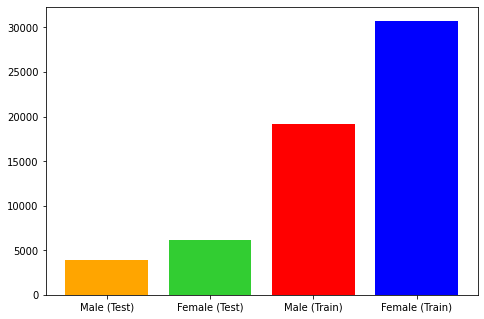

In [ ]:
def count_gender(data):
  """ Method that count number of male and female image in the given dataset """
  male: int = 0
  female: int = 0
  for d in data:
    if d == 1:
      male += 1
    else:
      female += 1
  return [male, female]

print(train_y)
# Repartition of men and woman images in train and test set
fig = pyplt.pyplot.figure()
ax = fig.add_axes([0, 0, 1, 1])
labels = ['Male (Test)', 'Female (Test)', 'Male (Train)', 'Female (Train)']
counts_test = count_gender(test_y)
counts_train = count_gender(train_y)
print("Test values: ", counts_test)
print("Train values: ", counts_train)
ax.bar(labels[0],counts_test[0], color ='orange')
ax.bar(labels[1],counts_test[1], color ='limegreen')
ax.bar(labels[2],counts_train[0], color ='r')
ax.bar(labels[3],counts_train[1], color ='b')
pyplt.pyplot.show()

We can see here that the train set is much bigger than the test set, and that in both sets there are more women images than men's

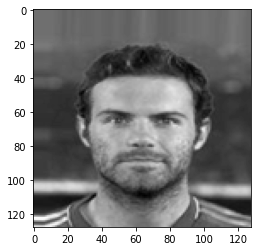

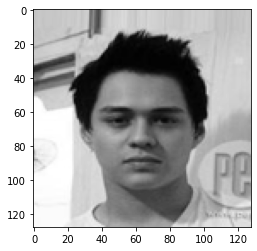

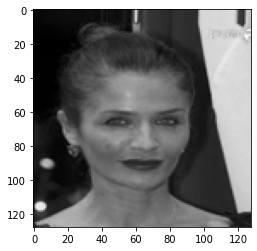

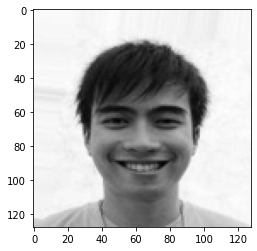

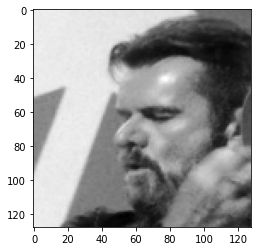

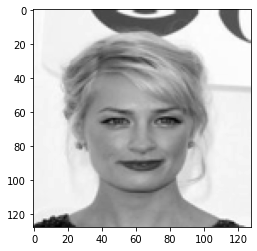

In [ ]:
# Printing some images to see what they looks like
images = os.listdir('data/img')
for i in range(6):
  pyplt.pyplot.figure()
  pyplt.pyplot.imshow(pyplt.pyplot.imread(os.path.join('data/img', images[i])),  cmap=pyplt.cm.gray)

## Building networks

Now that we have imported and sorted our images, it's time to build our networks. For each test we have made their will be a section that will explain our choices. We applied a well know methodology: at each test we'll change only one parameter to study it's influence on the network performances and then we'll combine some parameters and make some conclusion about it.

In [ ]:
# Defining some usefull variables for every networks first
batch_size = 128 # Number of images in each batch
num_classes = 2 # Number of possible classes
epochs = 10 # Number of training steps
image_size = (80, 80, 1) # Images size
# Defining an early stopping callback that stop the trainin of the network if no 
# significative improvements have been made during 3 epochs
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

### First network

For the first network we choose to implement a classic CNN architecture (a succession of Conv2D and MaxPooling layers) with not much layers to see if it's mandatory to have a deep network to have good results.

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)            

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

(5000, 48, 48)
Epoch 1/30
40/40 [==============================] - 45s 1s/step - loss: 0.8235 - accuracy: 0.6196 - val_loss: 0.6653 - val_accuracy: 0.6587
Epoch 2/30
40/40 [==============================] - 43s 1s/step - loss: 0.6406 - accuracy: 0.6628 - val_loss: 0.5491 - val_accuracy: 0.7164
Epoch 3/30
40/40 [==============================] - 42s 1s/step - loss: 0.6204 - accuracy: 0.6898 - val_loss: 0.7033 - val_accuracy: 0.6158
Epoch 4/30
40/40 [==============================] - 42s 1s/step - loss: 0.5333 - accuracy: 0.7402 - val_loss: 0.9197 - val_accuracy: 0.6193
Epoch 5/30
40/40 [==============================] - 42s 1s/step - loss: 0.4496 - accuracy: 0.7962 - val_loss: 0.4840 - val_accuracy: 0.7701
Epoch 6/30
40/40 [==============================] - 42s 1s/step - loss: 0.4044 - accuracy: 0.8162 - val_loss: 0.3596 - val_accuracy: 0.8370
Epoch 7/30
40/40 [==============================] - 43s 1s/step - loss: 0.3513 - accuracy: 0.8476 - val_loss: 0.3796 - val_accuracy: 0.8442
Epoch

So we obtained pretty good results with this first network ! No, let's try to upgrade it by changing parameters and see what it does.

### Second network

In this network we choose to increase the number of fully connected Dense layer to see if they really improve the results !

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10368)            

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
40/40 [==============================] - 46s 1s/step - loss: 0.6836 - accuracy: 0.6058 - val_loss: 0.6555 - val_accuracy: 0.6136
Epoch 2/30
40/40 [==============================] - 46s 1s/step - loss: 0.6300 - accuracy: 0.6536 - val_loss: 0.5876 - val_accuracy: 0.6873
Epoch 3/30
40/40 [==============================] - 45s 1s/step - loss: 0.5806 - accuracy: 0.7086 - val_loss: 0.6348 - val_accuracy: 0.6711
Epoch 4/30
40/40 [==============================] - 44s 1s/step - loss: 0.5220 - accuracy: 0.7310 - val_loss: 0.4934 - val_accuracy: 0.7635
Epoch 5/30
40/40 [==============================] - 44s 1s/step - loss: 0.4552 - accuracy: 0.7822 - val_loss: 0.4226 - val_accuracy: 0.8046
Epoch 6/30
40/40 [==============================] - 43s 1s/step - loss: 0.3802 - accuracy: 0.8256 - val_loss: 0.3777 - val_accuracy: 0.8409
Epoch 7/30
40/40 [==============================] - 43s 1s/step - loss: 0.3488 - accuracy: 0.8424 - val_loss: 1.4073 - val_accuracy: 0.6266
Epoch 8/30
40/40 [==

If compare this architecture to the previous one, we see that the validation 
accuracy is smaller than the previous one. So it's not necessarily usefull
to add some fully connected Dense layers to improve the network like this.

### Third network

In this test we'll take the first network and add some dropout to see the influence of this layer one the network performance.

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu')
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 9, 9, 128)        

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
40/40 [==============================] - 45s 1s/step - loss: 0.7802 - accuracy: 0.6206 - val_loss: 0.6358 - val_accuracy: 0.6373
Epoch 2/30
40/40 [==============================] - 45s 1s/step - loss: 0.6122 - accuracy: 0.6652 - val_loss: 0.9515 - val_accuracy: 0.6137
Epoch 3/30
40/40 [==============================] - 45s 1s/step - loss: 0.5689 - accuracy: 0.7208 - val_loss: 0.8407 - val_accuracy: 0.6303
Epoch 4/30
40/40 [==============================] - 45s 1s/step - loss: 0.5103 - accuracy: 0.7520 - val_loss: 0.5079 - val_accuracy: 0.7525
Epoch 5/30
40/40 [==============================] - 45s 1s/step - loss: 0.4290 - accuracy: 0.8046 - val_loss: 0.3900 - val_accuracy: 0.8261
Epoch 6/30
40/40 [==============================] - 46s 1s/step - loss: 0.3679 - accuracy: 0.8348 - val_loss: 0.3582 - val_accuracy: 0.8437
Epoch 7/30
40/40 [==============================] - 47s 1s/step - loss: 0.3399 - accuracy: 0.8470 - val_loss: 0.3322 - val_accuracy: 0.8536
Epoch 8/30
40/40 [==

This network has nearly the same performances as the first one with a droupout level that is usually used.

### Fourth network

In this try we'll see if combine Dense layers and Dropout make significative changes on the network performances

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 46, 46, 16)        160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 44, 44, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 18, 18, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 9, 128)        

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
40/40 [==============================] - 47s 1s/step - loss: 0.6770 - accuracy: 0.6084 - val_loss: 0.6601 - val_accuracy: 0.6698
Epoch 2/30
40/40 [==============================] - 45s 1s/step - loss: 0.6210 - accuracy: 0.6588 - val_loss: 0.6235 - val_accuracy: 0.6241
Epoch 3/30
40/40 [==============================] - 45s 1s/step - loss: 0.5268 - accuracy: 0.7310 - val_loss: 0.5151 - val_accuracy: 0.7379
Epoch 4/30
40/40 [==============================] - 45s 1s/step - loss: 0.4103 - accuracy: 0.8208 - val_loss: 0.3904 - val_accuracy: 0.8370
Epoch 5/30
40/40 [==============================] - 44s 1s/step - loss: 0.3563 - accuracy: 0.8408 - val_loss: 0.5406 - val_accuracy: 0.7683
Epoch 6/30
40/40 [==============================] - 44s 1s/step - loss: 0.3350 - accuracy: 0.8488 - val_loss: 0.3860 - val_accuracy: 0.8418
Epoch 7/30
40/40 [==============================] - 44s 1s/step - loss: 0.3051 - accuracy: 0.8670 - val_loss: 0.4072 - val_accuracy: 0.8265
Epoch 8/30
40/40 [==

After all this diffrents changes the network performances are not evolving as we can expect. So now let's change some network parameters like the optimizer and the learning rate to see if it has a bigger impact.

### Fifth network

In this attempt, we changed the RMSProp optimizer to Adam with the same learning rate as before.

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 32)      4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 58, 58, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 128)      

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
40/40 [==============================] - 3s 69ms/step - loss: 0.6581 - accuracy: 0.6288 - val_loss: 0.6093 - val_accuracy: 0.6866
Epoch 2/30
40/40 [==============================] - 2s 60ms/step - loss: 0.5665 - accuracy: 0.7092 - val_loss: 0.6481 - val_accuracy: 0.6852
Epoch 3/30
40/40 [==============================] - 2s 60ms/step - loss: 0.4749 - accuracy: 0.7722 - val_loss: 0.4734 - val_accuracy: 0.7646
Epoch 4/30
40/40 [==============================] - 2s 60ms/step - loss: 0.3786 - accuracy: 0.8330 - val_loss: 0.3490 - val_accuracy: 0.8418
Epoch 5/30
40/40 [==============================] - 2s 60ms/step - loss: 0.3181 - accuracy: 0.8608 - val_loss: 0.3156 - val_accuracy: 0.8600
Epoch 6/30
40/40 [==============================] - 2s 60ms/step - loss: 0.2963 - accuracy: 0.8688 - val_loss: 0.3016 - val_accuracy: 0.8679
Epoch 7/30
40/40 [==============================] - 2s 60ms/step - loss: 0.2922 - accuracy: 0.8740 - val_loss: 0.2944 - val_accuracy: 0.8688
Epoch 8/30
40

So here we have a better results than the first network we've made ! The Adam .optimizer is more performant than RMSProp in general because it's using RMSProp
combined with an other method called Momentum (to be short it's a much stronger gradient descent algorithm)

### Sixth network

After changin the optimizer, let's study the impact of the learning rate on the network performances ! We know that if we decrease the learning rate, the network will take much more time to reach an optimum and if we increase it too much there is a risk of divergence. So it's a parameter that needs to be set
carefully. In general we use 1e-3 because it's a default value but here we'll test something else. There are some interesting method used to change the learning rate during the training, and we implemented one just below. We used the LearningRateScheduler callback to make this implementation.

In [ ]:
 def step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=10):
    """ Method that create a LearningRateScheduler with step decay schedule"""
    def schedule(epoch):
        return initial_lr * (decay_factor ** np.floor(epoch/step_size))
    
    return LearningRateScheduler(schedule)

lr_sched = step_decay_schedule(initial_lr=1e-3, decay_factor=0.75, step_size=2)

model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=image_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-3),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 76, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0

In [ ]:
# Taking only a part of the images to reduce the training time
train_x_final = np.asarray(train_x)[:5000]
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)[:5000]
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback, lr_sched])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10
40/40 [==============================] - 39s 182ms/step - loss: 0.6273 - accuracy: 0.6530 - val_loss: 0.5326 - val_accuracy: 0.7288
Epoch 2/10
40/40 [==============================] - 6s 162ms/step - loss: 0.4301 - accuracy: 0.8020 - val_loss: 0.3488 - val_accuracy: 0.8426
Epoch 3/10
40/40 [==============================] - 6s 162ms/step - loss: 0.3184 - accuracy: 0.8646 - val_loss: 0.3328 - val_accuracy: 0.8524
Epoch 4/10
40/40 [==============================] - 6s 162ms/step - loss: 0.2807 - accuracy: 0.8782 - val_loss: 0.2887 - val_accuracy: 0.8720
Epoch 5/10
40/40 [==============================] - 6s 162ms/step - loss: 0.2507 - accuracy: 0.8876 - val_loss: 0.2918 - val_accuracy: 0.8709
Epoch 6/10
40/40 [==============================] - 7s 164ms/step - loss: 0.2296 - accuracy: 0.9016 - val_loss: 0.3042 - val_accuracy: 0.8648
Epoch 7/10
40/40 [==============================] - 6s 163ms/step - loss: 0.2088 - accuracy: 0.9072 - val_loss: 0.2996 - val_accuracy: 0.8747
Epoch

The network greatly improved this time ! We can conclude that evolving learning rate during training is a good point ! Let's use all the images during the training with this last version to see if it also improves our network !

### Test with every image

In [ ]:
# Taking all images
train_x_final = np.asarray(train_x)
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)
test_y_vector = to_categorical(test_y, num_classes=2)

# Train the model using the parameters defined earlier
history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                    callbacks = [callback, lr_sched])

# Finally, evaluate the model using the test data           
score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/10


ValueError: ignored

As we can expect the results are even better than before. Now the last test we've done is to adjust the training parameters to see which one are really improving the training of the network.

### Training parameters adjusting

We'll focus on the number of epochs and the batch_size because it's the two
parameter we can change without breaking everything. For the epochs we tested the following values: 40, 30, 20, 10 and for the batch_size we tested 256, 128, 64, 32. The test were made by changing those two parameters one by one to test all the combinations.

In [ ]:
batch_sizes = [256, 128, 64, 32] # Number of images in each batch
epochs = [40, 30, 20, 10] # Number of training steps

In [ ]:
# Taking all images
train_x_final = np.asarray(train_x)
test_x_final = np.asarray(test_x)
train_y_vector = to_categorical(train_y, num_classes=2)
test_y_vector = to_categorical(test_y, num_classes=2)

for i in batch_sizes:
  for j in epochs:
    # Train the model using the parameters defined earlier
    history = model.fit(train_x_final.reshape(train_x_final.shape[0], train_x_final.shape[1], train_x_final.shape[2], 1), train_y_vector,
                        batch_size=i,
                        epochs=j,
                        verbose=1,
                        validation_data=(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector),
                        callbacks = [callback, lr_sched])

    # Finally, evaluate the model using the test data           
    score = model.evaluate(test_x_final.reshape(test_x_final.shape[0], test_x_final.shape[1], test_x_final.shape[2], 1), test_y_vector, verbose=0)
    print("Parameters: (batch_size: " + str(i) + ", epochs: " + str(j) + ")")
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

Epoch 1/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0207 - accuracy: 0.9925 - val_loss: 0.6069 - val_accuracy: 0.8783
Epoch 2/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0218 - accuracy: 0.9920 - val_loss: 0.7351 - val_accuracy: 0.8815
Epoch 3/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0140 - accuracy: 0.9950 - val_loss: 0.8072 - val_accuracy: 0.8806
Epoch 4/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.6661 - val_accuracy: 0.8799
Epoch 5/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0108 - accuracy: 0.9964 - val_loss: 0.8184 - val_accuracy: 0.8806
Epoch 6/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0107 - accuracy: 0.9961 - val_loss: 0.7967 - val_accuracy: 0.8822
Epoch 7/40
196/196 [==============================] - 14s 69ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.8380 - val_accuracy: